# Breit-Wigner in Jordi's Code

Let's parametrise the Breit-Wigner using Jordi's formulation in numpy and tensorflow

Jordi Garra Tico's amplitude is defined as:

$$
\begin{align*}
BW(m) &= f_R f_D \frac{1}{(m_0^2 - m^2) + i m_0 \Gamma(m)} \Omega\\
\Gamma(m) &= \Gamma_0 \left(\frac{p}{p_0}\right)^3 \frac{m_0}{m} f_R^2 \\
f_R &= \sqrt{\frac{1+R_r^2p_0^2}{1+R_r^2p^2}} \quad \text{with} \quad R_r = 1.5 \\
f_D &= \sqrt{\frac{1+R_D^2 p_{D,0}^2}{1+R_D^2p_D^2}} \quad \text{with} \quad R_D = 5.0 \\
p &= \sqrt{\frac{(m^2-m_A^2-m_B^2)^2 - 4 m_A^2 m_B^2}{4 m^2}}\\
p_R &= \sqrt{\frac{(m_0^2-m_A^2-m_B^2)^2 - 4m_A^2m_B^2}{4 m_0^2}}\\
p_{D,0} &= \sqrt{\frac{(m_D^2-m_0^2-m_C^2)^2 - 4m_0^2*m_C^2}{4m_D^2}}\\
p_D &= \sqrt{\frac{(m_D^2-m^2-m_C^2)^2 - 4m^2*m_C^2}{4m_D^2}}\\
\Omega &= m_{AC}^2-m_{BC}^2+\frac{(m_D^2-m_C^2)(m_B^2-m_A^2)}{m^2}
\end{align*}
$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt

define the phase-space

In [4]:
# Masses of final state particles
import amplitf.interface as atfi
import amplitf.dynamics as atfd
import amplitf.kinematics as atfk
from amplitf.phasespace.dalitz_phasespace import DalitzPhaseSpace
from particle.particle import literals as lp
# Dalitz Particles
mkz = atfi.const(lp.K_S_0.mass/1000)
mpi = atfi.const(lp.pi_plus.mass/1000)
md = atfi.const(lp.D_0.mass/1000)
# Dalitz Phase Space
phsp = DalitzPhaseSpace(mpi, mkz, mpi, md)

In [12]:
def density_np(a):
    return np.abs(a)**2

In [39]:
pi180inv = np.pi / 180.

def helicity_np(mAB,mBC,mAC,mA,mB,mC,mD,spin):
    hel = np.where( spin==1, mAC*mAC-mBC*mBC+((mD*mD-mC*mC)*(mB*mB-mA*mA)/(mAB*mAB)),
                  np.where( spin==2, np.power(mBC*mBC-mAC*mAC+(mD*mD-mC*mC)*(mA*mA-mB*mB)/(mAB*mAB),2)-
                                    1./3.*(mAB*mAB-2.*(mD*mD+mC*mC)+np.power(mD*mD-mC*mC,2)/(mAB*mAB))*
                                    (mAB*mAB-2.*(mA*mA+mB*mB)+pow(mA*mA-mB*mB,2)/(mAB*mAB)),
                             1.0) )    
    return hel

def two_body_momentum_np(mAB,mA,mB):
    pAB = (((mAB*mAB-mA*mA-mB*mB)*(mAB*mAB-mA*mA-mB*mB)/4.0) - mA*mA*mB*mB)/(mAB*mAB)
    return np.where(pAB>0, np.sqrt(pAB), 0.)

def blatt_weisskopf_np(pR, pAB,radius,spin):
    r2 = radius*radius
    pAB2 = pAB*pAB
    pR2 = pR*pR
    bf= np.where( spin == 1, np.sqrt(1.0+r2*pR*pR)/np.sqrt(1.0+r2*pAB2),
                  np.where( spin == 2, np.sqrt(9.0+3.0*r2*pR2+r2*pR2*r2*pR2)/np.sqrt(9.0+3.0*r2*pAB2+r2*pAB2*r2*pAB2), 
                            1.0) )
    return bf

def amplitude_BW(v1, v2, v3,
                 ampl, phase, gamma, mass, spin,
                 mA, mB, mC, mMother):

    R_r = 1.5 # "resonance radius" for Blatt-Weisskoper barrier factors.
    R_D = 5.0 # "D meson radius" for Blatt-Weisskoper barrier factors.

    mAB=np.sqrt(v1) # = (_p4_d1+_p4_d2).mass();
    mBC=np.sqrt(v2) # = (_p4_d2+p4_d3).mass();
    mAC=np.sqrt(v3) # = (_p4_d1+p4_d3).mass();

    pAB=two_body_momentum_np(mAB, mA, mB)
    pR =two_body_momentum_np(mass, mA, mB)

    pMother=two_body_momentum_np(mMother, mass, mC)
    pDAB=two_body_momentum_np(mMother, mAB, mC)

    # Compute Blatt-Weisskopf barrier factors.
    fR= blatt_weisskopf_np(pR, pAB, R_r, spin)
    fD= blatt_weisskopf_np(pMother, pDAB, R_D, spin)
    power= 2.0*spin+1.0
    
    # Compute the running width.
    gammaAB= gamma*np.power(pAB/pR,power)*(mass/mAB)*fR*fR

    # Compute the amplitude.
    matrixEl = helicity_np(mAB,mBC,mAC,mA,mB,mC,mMother,spin)*fR*fD/(mass*mass-mAB*mAB-mass*gammaAB*1j)
    matrixEl *= ampl*complex(np.cos(phase*pi180inv),np.sin(phase*pi180inv))

    return matrixEl

Plot BW

In [5]:
nnorm=100000
norm_sample = phsp.uniform_sample(nnorm)

2025-05-20 17:09:48.748622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Calculate BW amplitude for $\rho(770)$

In [40]:
mrho = atfi.const(lp.rho_770_0.mass/1000)
wrho = atfi.const(lp.rho_770_0.width/1000)
srho = atfi.const(lp.rho_770_0.S)
amp_rho = atfi.const(1.0)
ph_rho = atfi.const(0.0)
bw_rho_amp = amplitude_BW(phsp.m2ac(norm_sample), phsp.m2ab(norm_sample), phsp.m2bc(norm_sample),
                 amp_rho.numpy(), ph_rho.numpy(), wrho.numpy(), mrho.numpy(), srho.numpy(),
                 mpi.numpy(), mpi.numpy(), mkz.numpy(), md.numpy())

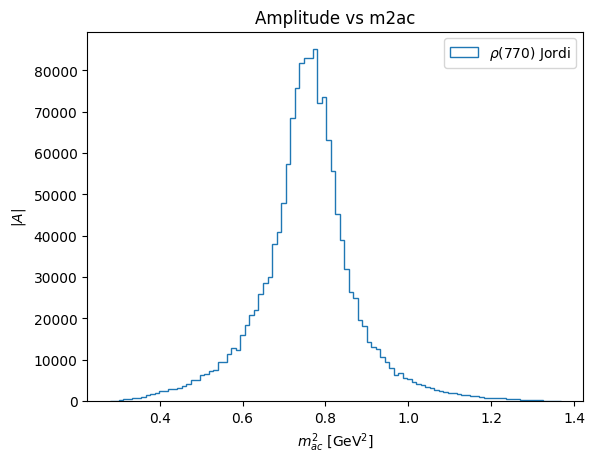

In [41]:
plt.hist(np.sqrt(phsp.m2ac(norm_sample)), weights = density_np(bw_rho_amp), bins=100, histtype='step', label=r'$\rho(770)$ Jordi')
#plt.hist(phsp.m2ab(norm_sample), weights = atfd.density(aBW_tf), bins=100, histtype='step', label='BW Amplitf', density=True)
plt.xlabel(r'$m_{ac}^2$ [GeV$^2$]')
plt.ylabel(r'$|A|$')
plt.title('Amplitude vs m2ac')
plt.legend()

AmpliTF Implementation

- test difference in `two_body_momentum`

In [56]:
mAB = phsp.m2ac(norm_sample)
test = two_body_momentum_np(np.sqrt(mAB), mpi, mpi) - atfk.two_body_momentum(atfi.sqrt(mAB), mpi, mpi)
print('Difference in two_body_momentum_np and two_body_momentum:', atfi.sum(test))

Difference in two_body_momentum_np and two_body_momentum: tf.Tensor(8.90741473635881e-13, shape=(), dtype=float64)


- test difference in `blatt_weisskopf_ff`

In [60]:
test = blatt_weisskopf_np(two_body_momentum_np(mrho, mpi, mpi), two_body_momentum_np(np.sqrt(mAB), mpi, mpi), 1.5, srho) - \
    atfd.blatt_weisskopf_ff(atfk.two_body_momentum(atfi.sqrt(mAB), mpi, mpi), atfk.two_body_momentum(mrho, mpi, mpi), atfi.const(1.5), 1)
print('Difference in blatt_weisskopf form factors:', atfi.sum(test))

Difference in blatt_weisskopf form factors: tf.Tensor(1.520894521434002e-12, shape=(), dtype=float64)


- test difference in helicity distribution

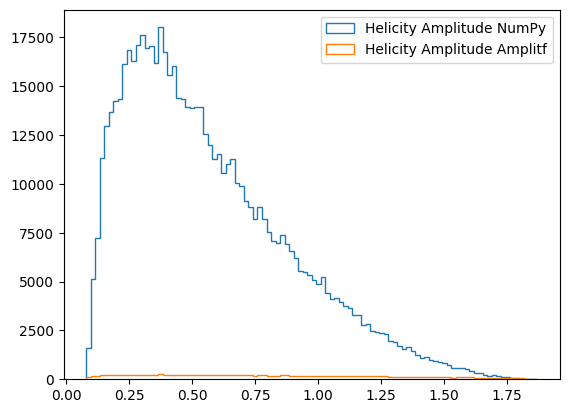

In [89]:
hel_np = helicity_np(phsp.m2ac(norm_sample), phsp.m2ab(norm_sample), phsp.m2bc(norm_sample),
                     mpi.numpy(), mpi.numpy(), mkz.numpy(), md.numpy(), 1)
hel_tf = atfd.helicity_amplitude(phsp.cos_helicity_ac(norm_sample), 1)
plt.hist(phsp.m2ac(norm_sample), weights=density_np(hel_np), bins=100, histtype='step', label='Helicity Amplitude NumPy')
plt.hist(phsp.m2ac(norm_sample), weights=atfd.density(hel_tf), bins=100, histtype='step', label='Helicity Amplitude Amplitf')
plt.legend()

Let's code the BW the way Jordi did

In [85]:
def helicity_tf(mAB,mBC,mAC,mA,mB,mC,mD,spin):
    hel = atfi.where( spin==1, mAC*mAC-mBC*mBC+((mD*mD-mC*mC)*(mB*mB-mA*mA)/(mAB*mAB)),
                  atfi.where( spin==2, atfi.pow(mBC*mBC-mAC*mAC+(mD*mD-mC*mC)*(mA*mA-mB*mB)/(mAB*mAB),2)-
                                    1./3.*(mAB*mAB-2.*(mD*mD+mC*mC)+atfi.pow(mD*mD-mC*mC,2)/(mAB*mAB))*
                                    (mAB*mAB-2.*(mA*mA+mB*mB)+atfi.pow(mA*mA-mB*mB,2)/(mAB*mAB)),
                             1.0) )    
    return hel


def amplitude_BW_tf(v1, v2, v3,
                 ampl, phase, gamma, mass, spin,
                 mA, mB, mC, mMother):

    R_r = 1.5 # "resonance radius" for Blatt-Weisskoper barrier factors.
    R_D = 5.0 # "D meson radius" for Blatt-Weisskoper barrier factors.

    mAB=atfi.sqrt(v1) # = (_p4_d1+_p4_d2).mass();
    mBC=atfi.sqrt(v2) # = (_p4_d2+p4_d3).mass();
    mAC=atfi.sqrt(v3) # = (_p4_d1+p4_d3).mass();

    pAB=atfk.two_body_momentum(mAB, mA, mB)
    pR =atfk.two_body_momentum(mass, mA, mB)

    pMother=atfk.two_body_momentum(mMother, mass, mC)
    pDAB=atfk.two_body_momentum(mMother, mAB, mC)

    # Compute Blatt-Weisskopf barrier factors.
    fR= atfd.blatt_weisskopf_ff(pAB, pR, R_r, spin)
    fD= atfd.blatt_weisskopf_ff(pDAB, pMother, R_D, spin)
    
    # Compute the running width.
    gammaAB = atfd.mass_dependent_width(mAB, mass, gamma, pAB, pR, fR, spin)

    # Compute the amplitude.
    #matrixEl = atfi.cast_complex(helicity_tf(mAB,mBC,mAC,mA,mB,mC,mMother,spin)*fR*fD)/atfi.complex(mass*mass-mAB*mAB,-mass*gammaAB)
    matrixEl = atfi.cast_complex(helicity_tf(mAB,mBC,mAC,mA,mB,mC,mMother,spin)*fR*fD)*atfd.relativistic_breit_wigner(v1,mass,gammaAB)
    matrixEl *= atfi.complex(ampl*atfi.cos(phase*pi180inv),ampl*atfi.sin(phase*pi180inv))

    return matrixEl

In [86]:
bw_rho_amp_tf = amplitude_BW_tf(phsp.m2ac(norm_sample), phsp.m2ab(norm_sample), phsp.m2bc(norm_sample),
                 amp_rho, ph_rho, wrho, mrho, 1,
                 mpi, mpi, mkz, md)

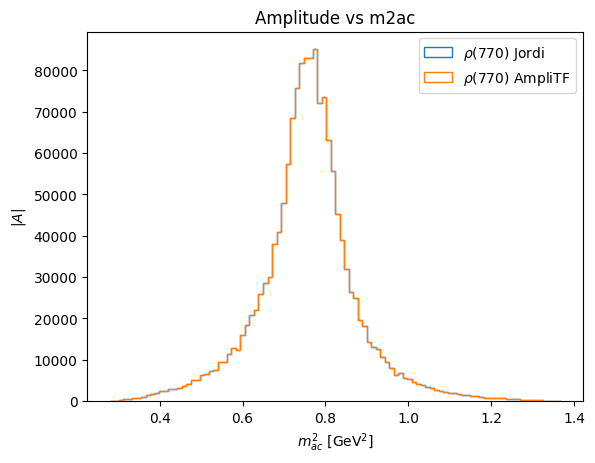

In [87]:
plt.hist(np.sqrt(phsp.m2ac(norm_sample)), weights = density_np(bw_rho_amp), bins=100, histtype='step', label=r'$\rho(770)$ Jordi')
plt.hist(np.sqrt(phsp.m2ac(norm_sample)), weights = atfd.density(bw_rho_amp_tf), bins=100, histtype='step', label=r'$\rho(770)$ AmpliTF')
#plt.hist(phsp.m2ab(norm_sample), weights = atfd.density(aBW_tf), bins=100, histtype='step', label='BW Amplitf', density=True)
plt.xlabel(r'$m_{ac}^2$ [GeV$^2$]')
plt.ylabel(r'$|A|$')
plt.title('Amplitude vs m2ac')
plt.legend()